# A Machine Learning Approach to Algorithmic Trading

We implement a Long Short-Term Memory (LSTM) neural network to predict stock price movements. It uses combination of technical indicators, fundamental data, and dimensionality reduction (PCA) to engineer features for the model. You can tell this was my very first attempt at using machine learning for algorithmic trading because of the sheer number of features I included. In my defence, I did know to use PCA after.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import torch

# For reproducibility purposes
torch.manual_seed(111)
np.random.seed(111)

## Step 2: Data Download and Preparation

In [2]:
ticker_symbol = "AAPL"
benchmark_symbol = "^GSPC"  # S&P 500
vix_symbol = "^VIX"         # Volatility Index
start_date = "2022-01-01"
end_date = "2026-01-24"

print(f"\n Downloading data for {ticker_symbol}, {benchmark_symbol}, and {vix_symbol}...")

# Download data
data = yf.download([ticker_symbol, benchmark_symbol, vix_symbol], start=start_date, end=end_date)

x = input(f"\n Annual or quarterly information?: ")

if x.lower() == "annual":
    print("Fetching Annual Data...")
    t_balance_sheet = yf.Ticker(ticker_symbol).balance_sheet.T
    t_financials = yf.Ticker(ticker_symbol).financials.T
    t_cashflow = yf.Ticker(ticker_symbol).cashflow.T

else:
    print("Fetching Quarterly Data...")
    t_balance_sheet = yf.Ticker(ticker_symbol).quarterly_balance_sheet.T
    t_financials = yf.Ticker(ticker_symbol).quarterly_financials.T
    t_cashflow = yf.Ticker(ticker_symbol).quarterly_cashflow.T

# Extract Close prices for simpler handling
close_df = data['Close'][[ticker_symbol, benchmark_symbol, vix_symbol]]

# Basic Data Cleaning
# Forward fill to handle any missing weekends/holidays differences between tickers
close_df.ffill(inplace=True)
close_df.dropna(inplace=True)

print(f"\n Successfully retrieved {len(close_df)} Close data points.")

# Ensure indices are timezone-naive to match price data
t_balance_sheet.index = pd.to_datetime(t_balance_sheet.index).tz_localize(None)
t_financials.index = pd.to_datetime(t_financials.index).tz_localize(None)
t_cashflow.index = pd.to_datetime(t_cashflow.index).tz_localize(None)

# Combine all fundamental data into one DataFrame
t = pd.concat([t_balance_sheet, t_financials, t_cashflow], axis=1)
t = t.loc[:, ~t.columns.duplicated()]
t.sort_index(inplace=True)

print(f"Combined Fundamental Data: {t.shape[1]} columns available.")

/tmp/ipython-input-1182467985.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download([ticker_symbol, benchmark_symbol, vix_symbol], start=start_date, end=end_date)
[*********************100%***********************]  3 of 3 completed



 Annual or quarterly information?: annual
Fetching Annual Data...

 Successfully retrieved 1018 Close data points.
Combined Fundamental Data: 161 columns available.


In [3]:
def get_col(df, term, keywords, andor):
    """
    Finds columns matching ALL keywords.
    - If 1 match: Returns it automatically.
    - If >1 match: Asks user to choose.
    - If 0 matches: Returns None.
    """
    # Find ALL matches
    if andor == 1:
        matches = [col for col in df.columns if all(k in str(col).lower() for k in keywords)] # Intersection
    else:
        matches = [col for col in df.columns if any(k in str(col).lower() for k in keywords)] # Union

    # Handle results
    if not matches:
        print(f"No columns found containing {term}.")
        return None

    if len(matches) == 1:
        # Perfect scenario, return the only match
        return matches[0]

    # Handle Ambiguity (More than 1 match)
    print(f"\n Ambiguity found for {term}:")
    for i, col in enumerate(matches):
        print(f" [{i}] {col}")

    # Ask user
    selection = input(f"Type number to select (0-{len(matches)-1}) or Enter for default [0]: ")

    if selection.isdigit():
        idx = int(selection)
        if 0 <= idx < len(matches):
            print(f"Selected: {matches[idx]}")
            return matches[idx]
        else:
            print("Invalid number selected. Defaulting to 0.")
            return matches[0]
    else:
        # Default fallback
        print(f"Defaulting to: {matches[0]}")
        return matches[0]

## Step 3: Feature Engineering

* **SMA (Simple Moving Average):** Identify trends over different windows (20, 50, 200 days)
* **MACD (Moving Average Convergence Divergence):** Momentum indicator
* **RSI (Relative Strength Index):** Momentum oscillator to identify overbought/oversold conditions
* **Stochastic Oscillator:** Compares a closing price to its price range over a given period
* **Relative Return:** Performance compared to the benchmark (S&P 500)

In [4]:
# Create a new DataFrame to hold all our features
features_df = pd.DataFrame(index=close_df.index)

# --- Market Data ---
features_df['Close'] = data['Close'][ticker_symbol]
features_df['High'] = data['High'][ticker_symbol]
features_df['Low'] = data['Low'][ticker_symbol]
features_df['Volume'] = data['Volume'][ticker_symbol]
features_df['VIX_Close'] = data['Close'][vix_symbol]

# --- Technical Indicators ---

# Simple Moving Averages (SMAs)
features_df['SMA_20'] = features_df['Close'].rolling(window=20).mean()
features_df['SMA_50'] = features_df['Close'].rolling(window=50).mean()
features_df['SMA_200'] = features_df['Close'].rolling(window=200).mean()

# Moving Average Convergence Divergence (MACD)
EMA_12 = features_df['Close'].ewm(span=12, adjust=False).mean()
EMA_26 = features_df['Close'].ewm(span=26, adjust=False).mean()
features_df['MACD'] = EMA_12 - EMA_26
features_df['MACD_Signal'] = features_df['MACD'].ewm(span=9, adjust=False).mean()

# Relative Strength Index (RSI)
delta = features_df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
features_df['RSI'] = 100 - (100 / (1 + rs))

# Stochastic Oscillator
low_14 = features_df['Low'].rolling(window=14).min()
high_14 = features_df['High'].rolling(window=14).max()
features_df['Percent_K'] = 100 * ((features_df['Close'] - low_14) / (high_14 - low_14))
features_df['Percent_D'] = features_df['Percent_K'].rolling(window=3).mean()

# Past Quarter Relative Return vs. Benchmark
stock_return = close_df[ticker_symbol].pct_change(periods=63) # 63 days = 1 quarter
benchmark_return = close_df[benchmark_symbol].pct_change(periods=63)
features_df['Relative_Return'] = stock_return - benchmark_return

print("Gottem")

Gottem


- **Assets**
- **Liabilities**
- **Market Capitalization**

In [5]:
# --- Fundamental Data Features ---
print("\n--- Searching for Assets/Liabilities")

as_col = get_col(t, "(Total) Assets", ['total', 'assets'], 1)
li_col = get_col(t, "(Total) Liabilities", ['total', 'liabilities'], 1)
shares_col = get_col(t, "(Basic) Shares", ['outstanding', 'share', 'shares'], 0)
d_shares_col = get_col(t, "(Diluted) Shares", ['outstanding', 'share', 'shares'], 0)

# Reindex and Assign safely
if as_col:
    features_df['Assets'] = t[as_col].reindex(features_df.index, method='ffill')
else:
    pass

if li_col:
    features_df['Liabilities'] = t[li_col].reindex(features_df.index, method='ffill')
else:
    pass

if shares_col:
    features_df['Market_Cap'] = features_df['Close'] * t[shares_col].reindex(features_df.index, method='ffill')
else:
    pass

if d_shares_col:
    features_df['Diluted_Market_Cap'] = features_df['Close'] * t[d_shares_col].reindex(features_df.index, method='ffill')
else:
    pass

print("Donebo Jumbo")


--- Searching for Assets/Liabilities

 Ambiguity found for (Total) Assets:
 [0] Total Assets
 [1] Total Non Current Assets
Type number to select (0-1) or Enter for default [0]: 0
Selected: Total Assets

 Ambiguity found for (Total) Liabilities:
 [0] Total Liabilities Net Minority Interest
 [1] Total Non Current Liabilities Net Minority Interest
Type number to select (0-1) or Enter for default [0]: 0
Selected: Total Liabilities Net Minority Interest

 Ambiguity found for (Basic) Shares:
 [0] Treasury Shares Number
 [1] Ordinary Shares Number
 [2] Share Issued
 [3] Diluted Average Shares
 [4] Basic Average Shares
Type number to select (0-4) or Enter for default [0]: 4
Selected: Basic Average Shares

 Ambiguity found for (Diluted) Shares:
 [0] Treasury Shares Number
 [1] Ordinary Shares Number
 [2] Share Issued
 [3] Diluted Average Shares
 [4] Basic Average Shares
Type number to select (0-4) or Enter for default [0]: 3
Selected: Diluted Average Shares
Donebo Jumbo


- **Earnings per Share**: Bruh
- **P/E Ratio**: It's just the P/E ratio

In [6]:
# --- P/E Ratio (which is surprisingly incredibly hard to get) ---
print("\n--- Searching for EPS Data ---")

eps_col = get_col(t, "(Basic) EPS", ['eps', 'earning', 'earnings'], 0)
d_eps_col = get_col(t, "(Diluted) EPS", ['eps', 'earning', 'earnings'], 0)

# P/E Ratio Calculation
if x.lower() == "annual":
    if eps_col:
        features_df['TTM_EPS'] = t[eps_col].reindex(features_df.index, method='ffill') # Trailing P/E uses total EPS of last 12 months, you looked this up already
        features_df['PE_Ratio'] = features_df['Close'] / features_df['TTM_EPS']
    else:
        pass

    if d_eps_col:
        features_df['TTM_Diluted_EPS'] = t[d_eps_col].reindex(features_df.index, method='ffill')
        features_df['Diluted_PE_Ratio'] = features_df['Close'] / features_df['TTM_Diluted_EPS']
    else:
        pass

else:
    if eps_col:
        features_df['TTM_EPS'] = t[eps_col].rolling(window=4).sum().reindex(features_df.index, method='ffill')
        features_df['PE_Ratio'] = features_df['Close'] / features_df['TTM_EPS']
    else:
        pass

    if d_eps_col:
        features_df['TTM_Diluted_EPS'] = t[d_eps_col].rolling(window=4).sum().reindex(features_df.index, method='ffill')
        features_df['Diluted_PE_Ratio'] = features_df['Close'] / features_df['TTM_Diluted_EPS']
    else:
        pass

print("Yep")


--- Searching for EPS Data ---

 Ambiguity found for (Basic) EPS:
 [0] Gains Losses Not Affecting Retained Earnings
 [1] Retained Earnings
 [2] Diluted EPS
 [3] Basic EPS
Type number to select (0-3) or Enter for default [0]: 3
Selected: Basic EPS

 Ambiguity found for (Diluted) EPS:
 [0] Gains Losses Not Affecting Retained Earnings
 [1] Retained Earnings
 [2] Diluted EPS
 [3] Basic EPS
Type number to select (0-3) or Enter for default [0]: 2
Selected: Diluted EPS
Yep


- **Cash Flow**: Also just cash flow
- **P/CF Ratio**: Price-to-cash flow ratio

In [7]:
# --- Cash Flow ---
print("\n--- Searching for Cash Flow Data ---")

ocf_col = get_col(t, "(Operating) Cash Flow", ['cash', 'flow', 'activities', 'operating'], 0)

# P/CF Ratio Calculation
if x.lower() == "annual":
    if ocf_col and shares_col:
        features_df['TTM_Operating_Cash_Flow'] = t[ocf_col].reindex(features_df.index, method='ffill')
        features_df['PCF_Ratio'] = features_df['Market_Cap'] / features_df['TTM_Operating_Cash_Flow']
    else:
        pass

    if ocf_col and d_shares_col:
        features_df['TTM_Operating_Cash_Flow'] = t[ocf_col].reindex(features_df.index, method='ffill')
        features_df['Diluted_PCF_Ratio'] = features_df['Diluted_Market_Cap'] / features_df['TTM_Operating_Cash_Flow']
    else:
        pass

else:
    if ocf_col and shares_col:
        features_df['TTM_Operating_Cash_Flow'] = t[ocf_col].rolling(window=4).sum().reindex(features_df.index, method='ffill')
        features_df['PCF_Ratio'] = features_df['Market_Cap'] / features_df['TTM_Operating_Cash_Flow']
    else:
        pass

    if ocf_col and d_shares_col:
        features_df['TTM_Operating_Cash_Flow'] = t[ocf_col].rolling(window=4).sum().reindex(features_df.index, method='ffill')
        features_df['Diluted_PCF_Ratio'] = features_df['Diluted_Market_Cap'] / features_df['TTM_Operating_Cash_Flow']
    else:
        pass

print("Yessir")


--- Searching for Cash Flow Data ---

 Ambiguity found for (Operating) Cash Flow:
 [0] Cash Cash Equivalents And Short Term Investments
 [1] Cash And Cash Equivalents
 [2] Cash Equivalents
 [3] Cash Financial
 [4] Total Operating Income As Reported
 [5] Other Non Operating Income Expenses
 [6] Net Non Operating Interest Income Expense
 [7] Interest Expense Non Operating
 [8] Interest Income Non Operating
 [9] Operating Income
 [10] Operating Expense
 [11] Operating Revenue
 [12] Free Cash Flow
 [13] End Cash Position
 [14] Beginning Cash Position
 [15] Changes In Cash
 [16] Financing Cash Flow
 [17] Cash Flow From Continuing Financing Activities
 [18] Cash Dividends Paid
 [19] Investing Cash Flow
 [20] Cash Flow From Continuing Investing Activities
 [21] Operating Cash Flow
 [22] Cash Flow From Continuing Operating Activities
 [23] Other Non Cash Items
Type number to select (0-23) or Enter for default [0]: 22
Selected: Cash Flow From Continuing Operating Activities
Yessir


- **Free Cash Flow Yield**
- **Revenue Growth**
- **Operating Margin**
- **Debt-to-Equity Ratio**
- **Return on Capital Employed**
- **EV/EBITDA Multiple**

In [8]:
# --- Advanced Fundamental Data Features (that some guy on Reddit told me to add) ---
print("\n--- Calculating Advanced Ratios (ROCE, Margins, Leverage) ---")

# A. Free Cash Flow Yield
fcf_col = get_col(t, "(Free) Cash Flow", ['cash', 'flow', 'free'], 0)

if x.lower() == "annual":
    if fcf_col and shares_col:
        features_df['TTM_Free_Cash_Flow'] = t[fcf_col].reindex(features_df.index, method='ffill')
        features_df['FCF_Yield'] = features_df['TTM_Free_Cash_Flow'] / features_df['Market_Cap']
    else:
        pass

    if fcf_col and d_shares_col:
        features_df['TTM_Free_Cash_Flow'] = t[fcf_col].reindex(features_df.index, method='ffill')
        features_df['Diluted_FCF_Yield'] = features_df['TTM_Free_Cash_Flow'] / features_df['Diluted_Market_Cap']
    else:
        pass

else:
    if fcf_col and shares_col:
        features_df['TTM_Free_Cash_Flow'] = t[fcf_col].rolling(window=4).sum().reindex(features_df.index, method='ffill')
        features_df['FCF_Yield'] = features_df['TTM_Free_Cash_Flow'] / features_df['Market_Cap']
    else:
        pass

    if fcf_col and d_shares_col:
        features_df['TTM_Free_Cash_Flow'] = t[fcf_col].rolling(window=4).sum().reindex(features_df.index, method='ffill')
        features_df['Diluted_FCF_Yield'] = features_df['TTM_Free_Cash_Flow'] / features_df['Diluted_Market_Cap']
    else:
        pass

# B. Revenue Growth (Year-over-Year)
rev_col = get_col(t, "(Total) Revenue", ['total', 'revenue'], 1)

if x.lower() == "annual":
    if rev_col:
        features_df['Rev_Growth_YoY'] = t[rev_col].pct_change(periods=1).reindex(features_df.index, method='ffill')
    else:
        pass

else:
    if rev_col:
        features_df['Rev_Growth_YoY'] = t[rev_col].pct_change(periods=4).reindex(features_df.index, method='ffill')
    else:
        pass

# C. Operating Margin
op_inc_col = get_col(t, "Operating Income", ['operating', 'income'], 1)

if x.lower() == "annual":
    if op_inc_col and rev_col:
        ttm_op_income = t[op_inc_col].reindex(features_df.index, method='ffill')
        ttm_revenue = t[rev_col].reindex(features_df.index, method='ffill')

        features_df['Op_Margin'] = ttm_op_income / ttm_revenue
    else:
        pass

else:
    if op_inc_col and rev_col:
        ttm_op_income = t[op_inc_col].rolling(window=4).sum().reindex(features_df.index, method='ffill')
        ttm_revenue = t[rev_col].rolling(window=4).sum().reindex(features_df.index, method='ffill')

        features_df['Op_Margin'] = ttm_op_income / ttm_revenue
    else:
        pass

# D. Debt-to-Equity
debt_col = get_col(t, "(Total) Debt", ['total', 'debt'], 1)
equity_col = get_col(t, "Shareholders' Equity", ['stockholder', 'stockholders', 'shareholder', 'shareholders', 'equity'], 0)

if debt_col and equity_col:
    daily_debt = t[debt_col].reindex(features_df.index, method='ffill')
    daily_equity = t[equity_col].reindex(features_df.index, method='ffill')

    features_df['DE_Ratio'] = daily_debt / daily_equity
else:
    pass

# E. Return on Capital Employed (ROCE)
curr_li_col = get_col(t, "(Current) Liabilities", ['current', 'liabilities'], 1)

# Using Operating Income as a proxy for EBIT
if x.lower() == "annual":
    if op_inc_col and as_col and curr_li_col:
        ttm_ebit = t[op_inc_col].reindex(features_df.index, method='ffill')

        daily_assets = t[as_col].reindex(features_df.index, method='ffill')
        daily_curr_li = t[curr_li_col].reindex(features_df.index, method='ffill')

        capital_employed = daily_assets - daily_curr_li

        features_df['ROCE'] = ttm_ebit / capital_employed
    else:
        pass

else:
    if op_inc_col and as_col and curr_li_col:
        ttm_ebit = t[op_inc_col].rolling(window=4).sum().reindex(features_df.index, method='ffill')

        daily_assets = t[as_col].reindex(features_df.index, method='ffill')
        daily_curr_li = t[curr_li_col].reindex(features_df.index, method='ffill')

        capital_employed = daily_assets - daily_curr_li

        features_df['ROCE'] = ttm_ebit / capital_employed
    else:
        pass

# F. EV / EBITDA
cash_col = get_col(t, "Cash, Cash Equivalents, or Short-Term Investments", ['cash', 'equivalents', 'investments'], 0)

# Using Operating Income as a proxy for EBITDA
if x.lower() == "annual":
    if 'Market_Cap' in features_df.columns and debt_col and cash_col and op_inc_col:
        daily_debt = t[debt_col].reindex(features_df.index, method='ffill')
        daily_cash = t[cash_col].reindex(features_df.index, method='ffill')

        ev = features_df['Market_Cap'] + daily_debt - daily_cash
        ttm_ebitda = t[op_inc_col].reindex(features_df.index, method='ffill')

        features_df['EV_EBITDA'] = ev / ttm_ebitda

    if 'Diluted_Market_Cap' in features_df.columns and debt_col and cash_col and op_inc_col:
        daily_debt = t[debt_col].reindex(features_df.index, method='ffill')
        daily_cash = t[cash_col].reindex(features_df.index, method='ffill')

        d_ev = features_df['Diluted_Market_Cap'] + daily_debt - daily_cash
        ttm_ebitda = t[op_inc_col].reindex(features_df.index, method='ffill')

        features_df['Diluted_EV_EBITDA'] = d_ev / ttm_ebitda
    else:
        pass

else:
    if 'Market_Cap' in features_df.columns and debt_col and cash_col and op_inc_col:
        daily_debt = t[debt_col].reindex(features_df.index, method='ffill')
        daily_cash = t[cash_col].reindex(features_df.index, method='ffill')

        ev = features_df['Market_Cap'] + daily_debt - daily_cash
        ttm_ebitda = t[op_inc_col].rolling(window=4).sum().reindex(features_df.index, method='ffill')

        features_df['EV_EBITDA'] = ev / ttm_ebitda

    if 'Diluted_Market_Cap' in features_df.columns and debt_col and cash_col and op_inc_col:
        daily_debt = t[debt_col].reindex(features_df.index, method='ffill')
        daily_cash = t[cash_col].reindex(features_df.index, method='ffill')

        d_ev = features_df['Diluted_Market_Cap'] + daily_debt - daily_cash
        ttm_ebitda = t[op_inc_col].rolling(window=4).sum().reindex(features_df.index, method='ffill')

        features_df['Diluted_EV_EBITDA'] = d_ev / ttm_ebitda
    else:
        pass

print("\n Advanced Ratios Complete.")


--- Calculating Advanced Ratios (ROCE, Margins, Leverage) ---

 Ambiguity found for (Free) Cash Flow:
 [0] Cash Cash Equivalents And Short Term Investments
 [1] Cash And Cash Equivalents
 [2] Cash Equivalents
 [3] Cash Financial
 [4] Free Cash Flow
 [5] End Cash Position
 [6] Beginning Cash Position
 [7] Changes In Cash
 [8] Financing Cash Flow
 [9] Cash Flow From Continuing Financing Activities
 [10] Cash Dividends Paid
 [11] Investing Cash Flow
 [12] Cash Flow From Continuing Investing Activities
 [13] Operating Cash Flow
 [14] Cash Flow From Continuing Operating Activities
 [15] Other Non Cash Items
Type number to select (0-15) or Enter for default [0]: 4
Selected: Free Cash Flow

 Ambiguity found for Operating Income:
 [0] Total Operating Income As Reported
 [1] Other Non Operating Income Expenses
 [2] Net Non Operating Interest Income Expense
 [3] Interest Income Non Operating
 [4] Operating Income
Type number to select (0-4) or Enter for default [0]: 4
Selected: Operating Income

In [9]:
# --- WEB SCRAPING AND SENTIMENT ANALYSIS (GOOGLE) ---
!pip install pytrends -q
import time
import urllib3
from urllib3.util import Retry
from tqdm.notebook import tqdm

# --- MONKEY PATCH: Fix for pytrends vs urllib3 2.0+ error ---
# pytrends passes 'method_whitelist' which was renamed to 'allowed_methods' in newer urllib3.
# This wrapper catches the old argument and maps it to the new one.
if not hasattr(Retry, 'method_whitelist'):
    original_init = Retry.__init__

    def new_init(self, *args, **kwargs):
        if 'method_whitelist' in kwargs:
            kwargs['allowed_methods'] = kwargs.pop('method_whitelist')
        original_init(self, *args, **kwargs)

    Retry.__init__ = new_init
# ------------------------------------------------------------

In [10]:
# Proceed
from pytrends.request import TrendReq
pytrends = TrendReq(hl='en-US', tz=360, timeout=(10,25), retries=2, backoff_factor=0.1)

print("\n--- Fetching Google Trends Data ---")

# Define Keywords
# Limit to 1-2 highly relevant terms to avoid rate limiting.
keywords = ['AAPL', 'iPhone']

# Construct the timeframe string dynamically
trends_timeframe = f"{start_date} {end_date}"
print(f"Requesting Trends timeframe: {trends_timeframe}")

try:
    pytrends.build_payload(keywords, cat=0, timeframe=trends_timeframe, geo='', gprop='')
    trends_df = pytrends.interest_over_time()

    if trends_df.empty:
        print("Warning: Google Trends returned empty data.")
        features_df['Trend_AAPL'] = 0
        features_df['Trend_iPhone'] = 0
    else:
        # Drop metadata
        if 'isPartial' in trends_df.columns:
            trends_df = trends_df.drop(columns=['isPartial'])

        # Reindex trends_df to match features_df (which starts in 2001)
        aligned_trends = trends_df.reindex(features_df.index, method='ffill')
        aligned_trends.fillna(0, inplace=True)

        # Assign to features
        features_df['Trend_AAPL'] = aligned_trends['AAPL']
        features_df['Trend_iPhone'] = aligned_trends['iPhone']

except Exception as e:
    print(f"Google Trends Error: {e}")
    features_df['Trend_AAPL'] = 0
    features_df['Trend_iPhone'] = 0


--- Fetching Google Trends Data ---
Requesting Trends timeframe: 2022-01-01 2026-01-24


In [11]:
# --- WEB SCRAPING AND SENTIMENT ANALYSIS (TWITTER) --- THIS DOESN'T WORK YET BUT DON'T GET YOUR HOPES UP
!pip install ntscraper -q
from ntscraper import Nitter

scraper = Nitter(log_level=1, skip_instance_check=False)

# Note: Nitter instances can be slow or rate-limited.
# We ask for "En" (English) tweets only to filter better.
stock = "AAPL" # Example stock
query = f"${stock}"

try:
    print(f"\nScraping tweets for {query}...")

    # Scrape 100 tweets
    # 'mode' can be 'term', 'hashtag', or 'user'
    tweets = scraper.get_tweets(query, mode='term', number=100)

    # Process data
    final_tweets = []

    if tweets['tweets']:
        for tweet in tweets['tweets']:
            final_tweets.append([
                tweet['date'],
                tweet['link'],
                tweet['text'],
                tweet['user']['username'],
                tweet['stats']['likes'],
                tweet['stats']['retweets']
            ])

        # Create DataFrame
        tweet_df = pd.DataFrame(final_tweets, columns=['Datetime', 'Link', 'Text', 'Username', 'Likes', 'Retweets'])

        # Convert date to datetime object
        tweet_df['Datetime'] = pd.to_datetime(tweet_df['Datetime'])

        print("\n--- Scraping Complete ---")
        print(tweet_df.head())
        print("\n Easy Peasy")
    else:
        print("No tweets found. Nitter instances might be busy. Try again in a minute.")
        print("Cringe")

except (IndexError, Exception) as e:
    print(f"Error encountered: {e}")
    print("Whatever")

Testing instances: 100%|██████████| 8/8 [00:05<00:00,  1.42it/s]


Scraping tweets for $AAPL...
Error encountered: Cannot choose from an empty sequence
Whatever


In [12]:
print("\n --- Index Diagnostics ---")
print(f"Price Index Type:       {features_df.index.dtype}")
print(f"Fundamentals Index Type: {t.index.dtype}")

print(f"\n Price Sample:       {features_df.index[0]}")
print(f"Fundamentals Sample: {t.index[0]}")

# Check for Timezone info
print(f"\n Price TZ:       {getattr(features_df.index, 'tz', 'None')}")
print(f"Fundamentals TZ: {getattr(t.index, 'tz', 'None')}")

# Check the first valid index for every column
print("--- Start Date by Feature ---")
for col in features_df.columns:
    first_valid = features_df[col].first_valid_index()
    print(f"{col}: Starts on {first_valid}")

# Drop columns that are >30% empty
limit = len(features_df) * 0.3
features_df_clean = features_df.dropna(axis=1, thresh=len(features_df) - limit)

print(f"\n Dropped columns: {set(features_df.columns) - set(features_df_clean.columns)}")

# Final Cleanup
# Drop rows where we have no data (e.g. the first year of data before TTM kicks in)
print(f"\n Shape before cleaning: {features_df_clean.shape}")
model_df = features_df_clean.dropna()
print(f"Shape after cleaning: {model_df.shape}")


 --- Index Diagnostics ---
Price Index Type:       datetime64[ns]
Fundamentals Index Type: datetime64[ns]

 Price Sample:       2022-01-03 00:00:00
Fundamentals Sample: 2021-09-30 00:00:00

 Price TZ:       None
Fundamentals TZ: None
--- Start Date by Feature ---
Close: Starts on 2022-01-03 00:00:00
High: Starts on 2022-01-03 00:00:00
Low: Starts on 2022-01-03 00:00:00
Volume: Starts on 2022-01-03 00:00:00
VIX_Close: Starts on 2022-01-03 00:00:00
SMA_20: Starts on 2022-01-31 00:00:00
SMA_50: Starts on 2022-03-15 00:00:00
SMA_200: Starts on 2022-10-18 00:00:00
MACD: Starts on 2022-01-03 00:00:00
MACD_Signal: Starts on 2022-01-03 00:00:00
RSI: Starts on 2022-01-21 00:00:00
Percent_K: Starts on 2022-01-21 00:00:00
Percent_D: Starts on 2022-01-25 00:00:00
Relative_Return: Starts on 2022-04-04 00:00:00
Assets: Starts on 2022-09-30 00:00:00
Liabilities: Starts on 2022-09-30 00:00:00
Market_Cap: Starts on 2022-09-30 00:00:00
Diluted_Market_Cap: Starts on 2022-09-30 00:00:00
TTM_EPS: Starts o

## Step 4: Preprocessing and Dimensionality Reduction

In [13]:
def stationarize_features(df):
    df_clean = df.copy()

    # Keywords for columns that must be differenced (Non-Stationary Trends)
    # These represent "Levels" or "Magnitudes" that grow over time.
    trend_keywords = [
        'Close', 'High', 'Low', 'Open',     # Prices
        'SMA', 'EMA',                       # Moving Averages
        'Volume',                           # Volume
        'Market_Cap',                       # Valuation Magnitude
        'TTM_',                             # Raw Fundamental Totals (e.g. TTM_Free_Cash_Flow)
        'Assets', 'Liabilities',            # Balance Sheet Totals
        'Equity', 'Debt'                    # Balance Sheet Totals
        'Trends', 'Search', 'Google',       # Google Trends
        'Hits', 'Interest'                  # Common trend column names
    ]

    # Keywords for columns to exclude from differencing (Already Stationary)
    # These are Ratios, Oscillators, or VIX (Mean Reverting)
    keep_keywords = [
        'Ratio', 'Yield', 'Margin',         # Valuation Ratios (PE, FCF Yield)
        'Growth',                           # Already a rate of change
        'RSI', 'MACD', 'VIX',               # Technical Oscillators
        'ROCE', 'ROA', 'ROE',               # Efficiency Ratios
        'Percent'                           # Stochastic Oscillator
    ]

    print(f"Starting Stationarity Check on {len(df_clean.columns)} columns...")

    converted_cols = []
    skipped_cols = []

    for col in df_clean.columns:
        # If it contains a "Keep Keyword", leave it alone
        # (e.g., "VIX_Close" contains "Close", but we want to keep VIX raw so we check VIX first).
        if any(k in col for k in keep_keywords):
            skipped_cols.append(col)
            continue

        # If it matches a "Trend Keyword", stationarize it
        if any(k in col for k in trend_keywords):
            try:
                # Use Log Returns: ln(t / t-1)
                new_col_name = f"{col}_Log_Ret"

                df_clean[new_col_name] = np.log(df_clean[col].replace(0, np.nan) / df_clean[col].shift(1).replace(0, np.nan))

                # Drop the original non-stationary column
                df_clean.drop(columns=[col], inplace=True)
                converted_cols.append(col)

            except Exception as e:
                print(f"Error transforming {col}: {e}. Skipping.")
        else:
            skipped_cols.append(col)

    # 3. Final Cleanup
    # The first row will now be NaN (because of shift(1)), so we drop it.
    df_clean.dropna(inplace=True)

    print(f"\nSummary:")
    print(f"Stationarized {len(converted_cols)} features (Prices/Totals).")
    print(f"Kept {len(skipped_cols)} features (Ratios/Oscillators).")

    return df_clean

# --- Apply the function ---
final_model_data = stationarize_features(model_df)

# Check the new shape and columns
print(f"\nFinal Dataset Shape: {final_model_data.shape}")
print("Columns ready for ML:")
print(final_model_data.columns.tolist())

Starting Stationarity Check on 35 columns...

Summary:
Stationarized 15 features (Prices/Totals).
Kept 20 features (Ratios/Oscillators).

Final Dataset Shape: (818, 35)
Columns ready for ML:
['VIX_Close', 'MACD', 'MACD_Signal', 'RSI', 'Percent_K', 'Percent_D', 'Relative_Return', 'PE_Ratio', 'Diluted_PE_Ratio', 'PCF_Ratio', 'Diluted_PCF_Ratio', 'FCF_Yield', 'Diluted_FCF_Yield', 'Op_Margin', 'DE_Ratio', 'ROCE', 'EV_EBITDA', 'Diluted_EV_EBITDA', 'Trend_AAPL', 'Trend_iPhone', 'Close_Log_Ret', 'High_Log_Ret', 'Low_Log_Ret', 'Volume_Log_Ret', 'SMA_20_Log_Ret', 'SMA_50_Log_Ret', 'SMA_200_Log_Ret', 'Assets_Log_Ret', 'Liabilities_Log_Ret', 'Market_Cap_Log_Ret', 'Diluted_Market_Cap_Log_Ret', 'TTM_EPS_Log_Ret', 'TTM_Diluted_EPS_Log_Ret', 'TTM_Operating_Cash_Flow_Log_Ret', 'TTM_Free_Cash_Flow_Log_Ret']


--- Generating Plots ---


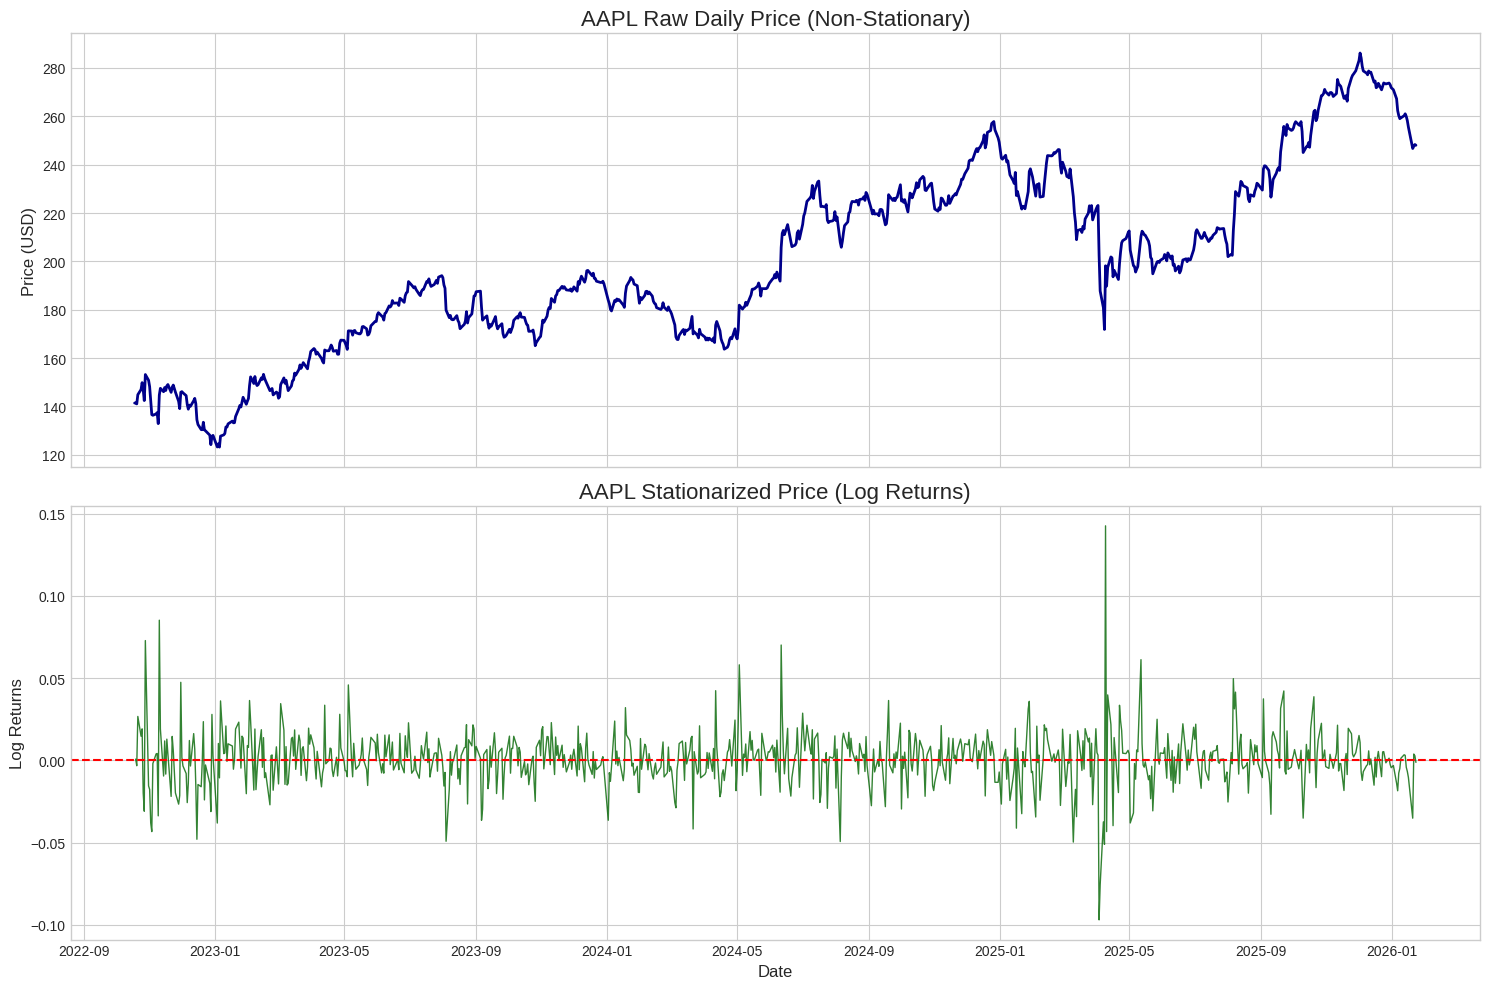

In [14]:
print("--- Generating Plots ---")

plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Plot 1: Raw Price (Non-Stationary)
ax1.plot(model_df.index, model_df['Close'], color='darkblue', linewidth=2)
ax1.set_title(f'{ticker_symbol} Raw Daily Price (Non-Stationary)', fontsize=16)
ax1.set_ylabel('Price (USD)', fontsize=12)

# Plot 2: Stationarized Price (Daily % Change)
ax2.plot(final_model_data.index, final_model_data['Close_Log_Ret'], color='darkgreen', linewidth=1, alpha=0.8)
ax2.set_title(f'{ticker_symbol} Stationarized Price (Log Returns)', fontsize=16)
ax2.set_ylabel('Log Returns', fontsize=12)
ax2.axhline(0, color='red', linestyle='--', linewidth=1.5, label='Zero Mean')

plt.xlabel('Date', fontsize=12)
plt.tight_layout()
plt.show()

I need to split my X dataframe into sequences before applying PCA. PCA should be fit only on the training set. Otherwise, information from the validation and test sets will leak into training. To be fair, the model was already garbage before this fix, but I gotta stay true to myself so...


In [15]:
X = final_model_data.copy()

# Align Targets
# Target: Next day's return * 100
target = (close_df[ticker_symbol].pct_change().shift(-1)) * 100
y = target.loc[X.index]

# Drop the last row because target is NaN (shift -1)
X = X.iloc[:-1]
y = y.iloc[:-1]

# Define Split Indices First
# We split indices based on raw data length
train_end = int(len(X) * 0.7)
val_end = int(len(X) * 0.9) # 70% Train, 20% Val, 10% Test

# C. Isolate Training Data for Fitting
X_train_raw = X.iloc[:train_end]

if not X.empty:
    scaler = StandardScaler()
    scaler.fit(X_train_raw) # Fit only on training
    X_scaled = scaler.transform(X) # Transform everything
    X_train_scaled = X_scaled[:train_end]

    # Keep enough components to explain 95% of the variance
    pca = PCA(n_components=0.95)
    pca.fit(X_train_scaled) # Fit only on training
    X_pca = pca.transform(X_scaled)

    # --- Print Results ---
    print(f"Original number of features: {X.shape[1]}")
    print(f"Number of features after PCA: {pca.n_components_}")
    print(f"Explained variance: {sum(pca.explained_variance_ratio_):.2f}")
    print("\n--- Original Features ---")
    print(X.columns.tolist())
    print("\n--- Shape of final feature set (X_pca) ---")
    print(X_pca.shape)
else:
    print("--- Data Processing Error ---")
    print("The DataFrame is empty after cleaning. Not enough historical data for the chosen indicators.")

Original number of features: 35
Number of features after PCA: 12
Explained variance: 0.96

--- Original Features ---
['VIX_Close', 'MACD', 'MACD_Signal', 'RSI', 'Percent_K', 'Percent_D', 'Relative_Return', 'PE_Ratio', 'Diluted_PE_Ratio', 'PCF_Ratio', 'Diluted_PCF_Ratio', 'FCF_Yield', 'Diluted_FCF_Yield', 'Op_Margin', 'DE_Ratio', 'ROCE', 'EV_EBITDA', 'Diluted_EV_EBITDA', 'Trend_AAPL', 'Trend_iPhone', 'Close_Log_Ret', 'High_Log_Ret', 'Low_Log_Ret', 'Volume_Log_Ret', 'SMA_20_Log_Ret', 'SMA_50_Log_Ret', 'SMA_200_Log_Ret', 'Assets_Log_Ret', 'Liabilities_Log_Ret', 'Market_Cap_Log_Ret', 'Diluted_Market_Cap_Log_Ret', 'TTM_EPS_Log_Ret', 'TTM_Diluted_EPS_Log_Ret', 'TTM_Operating_Cash_Flow_Log_Ret', 'TTM_Free_Cash_Flow_Log_Ret']

--- Shape of final feature set (X_pca) ---
(817, 12)


## Step 5: Actual Machine Learning Now

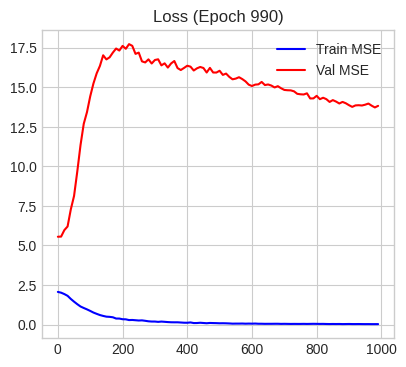


--- Training Complete ---


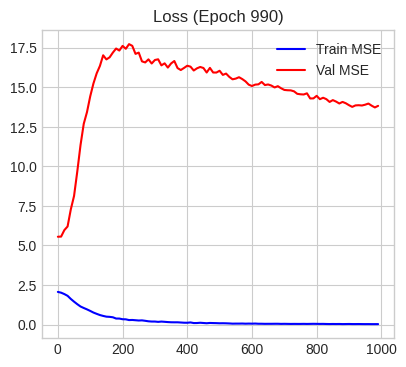

In [16]:
# --- Regression Attempt ---

import torch
import torch.nn as nn
import torch.optim as optim
from IPython import display

# --- 1. Data Prep ---
# Target: Next day's return * 100
target = (close_df[ticker_symbol].pct_change().shift(-1)) * 100

# Align target index
y = target.loc[X.index]

# Create Sequences
sequence_length = 20
X_sequences, y_sequences = [], []

for i in range(len(X_pca) - sequence_length):
    X_sequences.append(X_pca[i:i+sequence_length])
    y_sequences.append(y.iloc[i+sequence_length-1])

X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

# Train/Val/Test Split
train_size = int(0.7 * len(X_sequences))
val_size = int(0.2 * len(X_sequences))

X_train = torch.tensor(X_sequences[:train_size], dtype=torch.float32)
y_train = torch.tensor(y_sequences[:train_size], dtype=torch.float32).unsqueeze(1)

X_val = torch.tensor(X_sequences[train_size:train_size+val_size], dtype=torch.float32)
y_val = torch.tensor(y_sequences[train_size:train_size+val_size], dtype=torch.float32).unsqueeze(1)

X_test = torch.tensor(X_sequences[train_size+val_size:], dtype=torch.float32)
y_test = torch.tensor(y_sequences[train_size+val_size:], dtype=torch.float32).unsqueeze(1)

# --- 2. Model Definition ---
class StockLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(StockLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Added dropout to prevent overfitting
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_size = X_pca.shape[1]
hidden_size = 128
num_layers = 2
output_size = 1

model = StockLSTM(input_size, hidden_size, output_size, num_layers)

# --- 3. Training Setup ---

learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Loss Function
cost_func = nn.MSELoss()

# Early Stopping Parameters
patience = 1000
best_val_loss = float('inf')
patience_counter = 0

N_epochs = 1000 # Reduced from 10,000 (quality > quantity)
epoch_list, train_losses, val_losses = [], [], []

print("\n--- Starting Model Training (Regression) ---")

for epoch in range(N_epochs):
    model.train()
    optimizer.zero_grad()
    train_output = model(X_train)
    train_cost = cost_func(train_output, y_train)
    train_cost.backward()
    optimizer.step()

    # Validation
    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            val_output = model(X_val)
            val_cost = cost_func(val_output, y_val)

            # Calculate Directional Accuracy
            # Did we predict the sign correctly? (+/-)
            # (pred * actual) > 0 implies they have the same sign
            correct_direction = ((val_output * y_val) > 0).float()
            direction_acc = correct_direction.mean() * 100

        # Early Stopping Logic
        if val_cost < best_val_loss:
            best_val_loss = val_cost
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1

        epoch_list.append(epoch)
        train_losses.append(train_cost.item())
        val_losses.append(val_cost.item())

        # Plotting
        plt.figure(1, figsize=(10, 4))
        plt.clf()
        plt.subplot(1, 2, 1)
        plt.plot(epoch_list, train_losses, 'b', label='Train MSE')
        plt.plot(epoch_list, val_losses, 'r', label='Val MSE')
        plt.title(f"Loss (Epoch {epoch})")
        plt.legend()

        # Display Text
        print(f"Epoch {epoch} | Val MSE: {val_cost.item():.4f} | Dir Acc: {direction_acc:.1f}%")
        display.clear_output(wait=True)
        display.display(plt.gcf())

        if patience_counter >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch}")
            break

# Load best model for testing
model.load_state_dict(torch.load('best_model.pth'))
print("\n--- Training Complete ---")

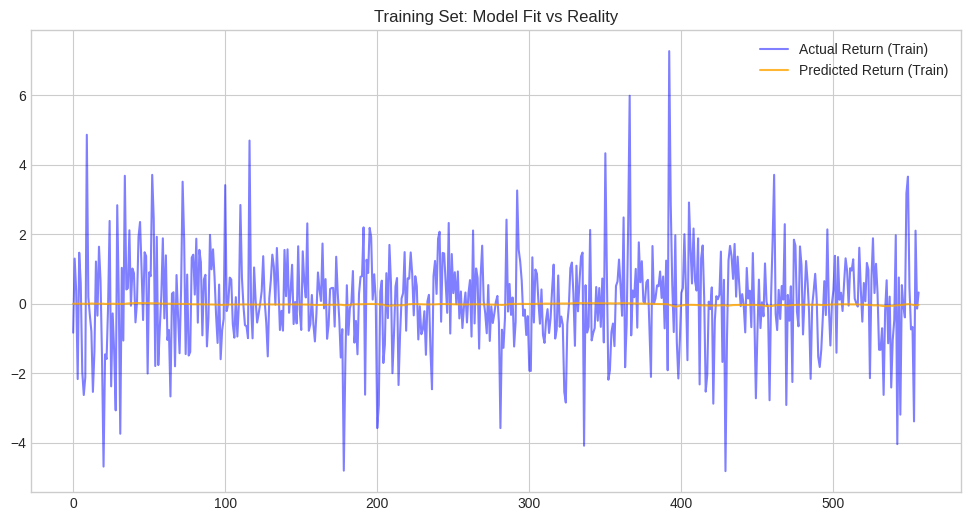

Training Directional Accuracy: 45.24%
Training MSE:                2.047683
STATUS: Underfitting. The model is guessing or predicting the mean.


In [17]:
# --- Visual Check on Training Data ---
model.eval()
with torch.no_grad():
    # Get predictions on the training set
    train_pred = model(X_train).cpu().numpy()
    train_actual = y_train.cpu().numpy()

# Plot Prediction vs Reality
plt.figure(figsize=(12, 6))
plt.plot(train_actual, label='Actual Return (Train)', alpha=0.5, color='blue')
plt.plot(train_pred, label='Predicted Return (Train)', alpha=0.8, color='orange')
plt.title('Training Set: Model Fit vs Reality')
plt.legend()
plt.show()

# Calculate Metrics on Training Data
# Directional Accuracy
train_matches = (np.sign(train_pred) == np.sign(train_actual))
train_acc = np.mean(train_matches) * 100

# MSE
train_mse = np.mean((train_actual - train_pred)**2)

print(f"Training Directional Accuracy: {train_acc:.2f}%")
print(f"Training MSE:                {train_mse:.6f}")

# Interpretation Helper
if train_acc > 55.0 and train_acc < 65.0:
    print("STATUS: Healthy Learning. The model sees a pattern.")
elif train_acc >= 65.0:
    print("STATUS: Caution. High accuracy might indicate Overfitting (Memorization).")
elif train_acc <= 52.0:
    print("STATUS: Underfitting. The model is guessing or predicting the mean.")

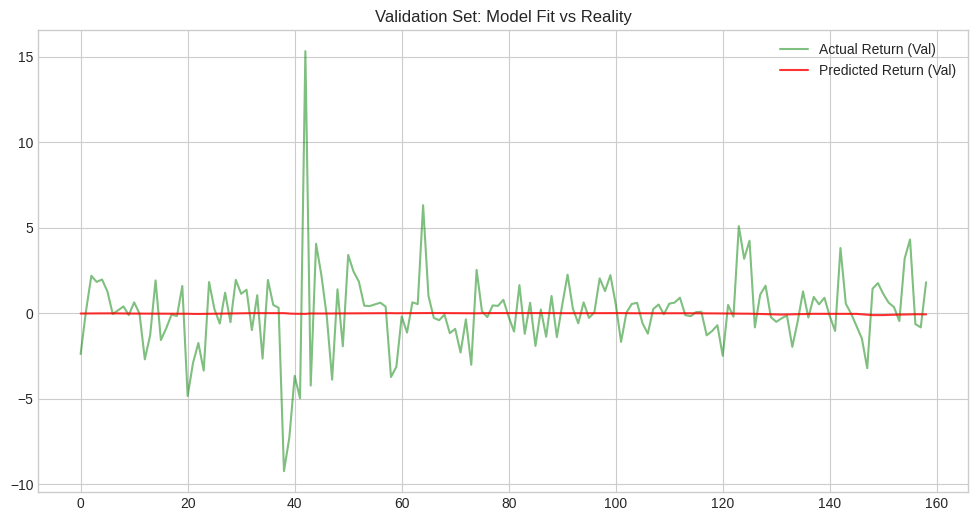

Validation Directional Accuracy: 45.91%
Validation MSE:                5.550830

--- DIAGNOSIS ---
BAD: The model is worse than a coin flip on new data.


In [18]:
# --- Visual Check on Validation Data ---
model.eval()
with torch.no_grad():
    # Get predictions on the validation set
    val_pred = model(X_val).cpu().numpy()
    val_actual = y_val.cpu().numpy()

# Plot Prediction vs Reality
plt.figure(figsize=(12, 6))
plt.plot(val_actual, label='Actual Return (Val)', alpha=0.5, color='green')
plt.plot(val_pred, label='Predicted Return (Val)', alpha=0.8, color='red')
plt.title('Validation Set: Model Fit vs Reality')
plt.legend()
plt.show()

# Calculate Metrics on Validation Data
# Directional Accuracy
val_matches = (np.sign(val_pred) == np.sign(val_actual))
val_acc = np.mean(val_matches) * 100

# MSE
val_mse = np.mean((val_actual - val_pred)**2)

print(f"Validation Directional Accuracy: {val_acc:.2f}%")
print(f"Validation MSE:                {val_mse:.6f}")

# Interpretation Helper
print(f"\n--- DIAGNOSIS ---")
if val_acc > 52.0:
    print("GOOD: The model generalizes well to unseen data.")
elif val_acc < 50.0:
    print("BAD: The model is worse than a coin flip on new data.")
else:
    print("NEUTRAL: The model is essentially random guessing (approx 50%).")

# Check for Overfitting Gap
# (Assuming you ran the training check before this)
try:
    gap = train_acc - val_acc
    if gap > 10.0:
        print(f"WARNING: Overfitting detected. Train Acc is {gap:.1f}% higher than Val Acc.")
except NameError:
    pass # train_acc variable might not exist if you didn't run the previous block

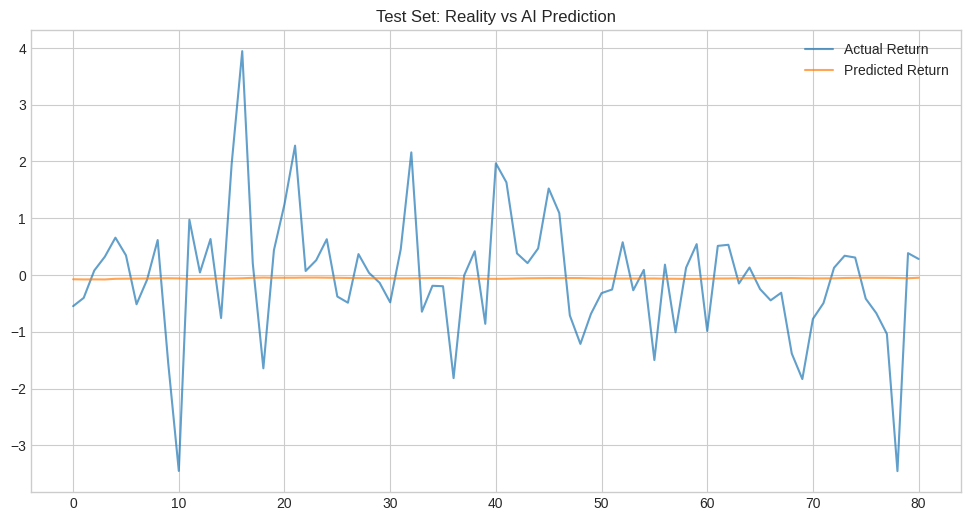

Directional Accuracy: 48.15%
Baseline MSE (Zero Pred): 1.199720
Model MSE:              1.200372
RESULT: Model is worse than doing nothing.


In [19]:
# --- Visual Check on Testing Data ---
model.eval()
with torch.no_grad():
    # Get predictions
    test_pred = model(X_test).cpu().numpy()
    test_actual = y_test.cpu().numpy()

# 1. Plot Prediction vs Reality
plt.figure(figsize=(12, 6))
plt.plot(test_actual, label='Actual Return', alpha=0.7)
plt.plot(test_pred, label='Predicted Return', alpha=0.7)
plt.title('Test Set: Reality vs AI Prediction')
plt.legend()
plt.show()

# Calculate Metrics on Validation Data
# Directional Accuracy
matches = (np.sign(test_pred) == np.sign(test_actual))
accuracy = np.mean(matches) * 100

print(f"Directional Accuracy: {accuracy:.2f}%")

# Baseline Check
# Does the model beat simply guessing "0" every day?
baseline_mse = np.mean(test_actual**2)
model_mse = np.mean((test_actual - test_pred)**2)

print(f"Baseline MSE (Zero Pred): {baseline_mse:.6f}")
print(f"Model MSE:              {model_mse:.6f}")

if model_mse < baseline_mse:
    print("RESULT: Model is adding value (Beating Zero).")
else:
    print("RESULT: Model is worse than doing nothing.")

Wonderful, it's all garbage. I am also aware there are loads of problems with this model, I'll fix them in the next ML version